In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [2]:
from torch.optim import lr_scheduler

In [3]:
from sklearn.metrics import balanced_accuracy_score

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
import pandas as pd
import pickle

In [6]:
import torch.utils.data as utils

In [7]:
import numpy as np

In [8]:
from barbar import Bar

In [9]:
import time

In [10]:
torch.manual_seed(27)

In [11]:
%matplotlib inline 
import matplotlib.pyplot as plt

In [12]:
def plot_acc(history):
    fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
    axarr[0].plot(range(0, len(history)), history['acc'], label='train score')
    axarr[0].plot(range(0, len(history)), history['val_acc'], label='test score')
    axarr[0].set_xlabel('Number of Epochs x 14', fontsize=18)
    axarr[0].set_ylabel('Accuracy', fontsize=18)
    axarr[0].set_ylim([0,1])
    axarr[1].plot(range(0, len(history)), history['acc'], label='train score')
    axarr[1].plot(range(0, len(history)), history['val_acc'], label='test score')
    axarr[1].set_xlabel('Number of Epochs x 14', fontsize=18)
    axarr[1].set_ylabel('Accuracy', fontsize=18)
    axarr[1].set_ylim([0.7,1])
    plt.legend()
    plt.show()

In [13]:
DATAPATH = 'data/features/'
MODELPATH = 'output/models/'

### STEP 2: LOADING DATASET 

In [16]:
class CattleSoundDataset(Dataset):
    """ FreeSound dataset."""

    # Initialize your data, download, etc.
    def __init__(self, X, y):
        
        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X)
        self.y_data = torch.from_numpy(y)

    def __getitem__(self, index):
        return (self.x_data[index], self.y_data[index])

    def __len__(self):
        return self.len

In [17]:
X_train = np.load('data/train_test/X_mfcc_train.npy')

In [18]:
X_test = np.load('data/train_test/X_mfcc_test.npy')

In [19]:
y_train = np.load('data/train_test/y_mfcc_train.npy')

In [20]:
y_test = np.load('data/train_test/y_mfcc_test.npy')

In [21]:
print('X_train:', X_train.shape)

print('X_test:', X_test.shape)

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (1072, 60, 35)
X_test: (460, 60, 35)
y_train: (1072,)
y_test: (460,)


In [22]:
train_dataset = CattleSoundDataset(X_train, y_train)

In [23]:
test_dataset = CattleSoundDataset(X_test, y_test)

### STEP 2: MAKING DATASET ITERABLE

In [24]:
batch_size = 32
n_iters = 1000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [25]:
num_epochs

29

In [26]:
transformations = transforms.Compose([transforms.ToTensor()])

In [27]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size= batch_size, 
                                           shuffle=True)

In [28]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [29]:
dataset_sizes = {'train':len(train_loader.dataset),'valid':len(test_loader.dataset)}

In [30]:
dataloaders = {'train':train_loader,'valid':test_loader}

### STEP 3: CREATE MODEL CLASS

In [31]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.max_pool = nn.MaxPool2d(2)
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        return x

In [32]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=1, out_channels=32),
            ConvBlock(in_channels=32, out_channels=64),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7680, 1024),
            nn.PReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.1),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        #x = torch.mean(x, dim=3)
        #x, _ = torch.max(x, dim=2)
        out = self.fc(out)
        return out

### STEP 4: INSTANTIATE MODEL CLASS

In [33]:
model = CNNModel(num_classes=3)

In [34]:
#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

### STEP 5: INSTANTIATE LOSS CLASS

In [35]:
criterion = nn.CrossEntropyLoss().cuda()

### STEP 6: INSTANTIATE OPTIMIZER CLASS

In [36]:
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### STEP 7: TRAIN THE MODEL

In [45]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, graph=False):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    history = pd.DataFrame()
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Calculate Accuracy         
            y_pred = []
            y_true = []

            
            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs = Variable(inputs.unsqueeze(1).cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs.unsqueeze(1)), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                outputs = model(inputs.to(dtype=torch.float))
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
                
                if torch.cuda.is_available():
                    y_pred += preds.cpu().numpy().tolist()
                    y_true += labels.cpu().numpy().tolist()
                    
                else:
                    y_pred += preds.numpy()
                    y_true += labels.numpy()
        
                

            epoch_loss = running_loss / dataset_sizes[phase]
            #epoch_acc = running_corrects / dataset_sizes[phase]
            epoch_acc = balanced_accuracy_score(y_true, y_pred)
            
            if phase == 'train':
                train_acc.append(epoch_acc)
            else:
                val_acc.append(epoch_acc)
            
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    history['val_acc'] = val_acc
    history['acc'] = train_acc
    
    if graph:
        print()
        print('==========' * 10)
        plot_acc(history)
        
        
    
    
    return model

Epoch 0/28
----------
train Loss: 0.0040 Acc: 0.9444
valid Loss: 0.0202 Acc: 0.7659

Epoch 1/28
----------
train Loss: 0.0044 Acc: 0.9373
valid Loss: 0.0200 Acc: 0.7678

Epoch 2/28
----------
train Loss: 0.0051 Acc: 0.9331
valid Loss: 0.0199 Acc: 0.7653

Epoch 3/28
----------
train Loss: 0.0046 Acc: 0.9404
valid Loss: 0.0200 Acc: 0.7635

Epoch 4/28
----------
train Loss: 0.0043 Acc: 0.9365
valid Loss: 0.0199 Acc: 0.7653

Epoch 5/28
----------
train Loss: 0.0039 Acc: 0.9503
valid Loss: 0.0198 Acc: 0.7629

Epoch 6/28
----------
train Loss: 0.0049 Acc: 0.9261
valid Loss: 0.0196 Acc: 0.7653

Epoch 7/28
----------
train Loss: 0.0049 Acc: 0.9406
valid Loss: 0.0199 Acc: 0.7513

Epoch 8/28
----------
train Loss: 0.0041 Acc: 0.9504
valid Loss: 0.0197 Acc: 0.7592

Epoch 9/28
----------
train Loss: 0.0044 Acc: 0.9383
valid Loss: 0.0197 Acc: 0.7612

Epoch 10/28
----------
train Loss: 0.0039 Acc: 0.9516
valid Loss: 0.0201 Acc: 0.7678

Epoch 11/28
----------
train Loss: 0.0048 Acc: 0.9314
valid Loss

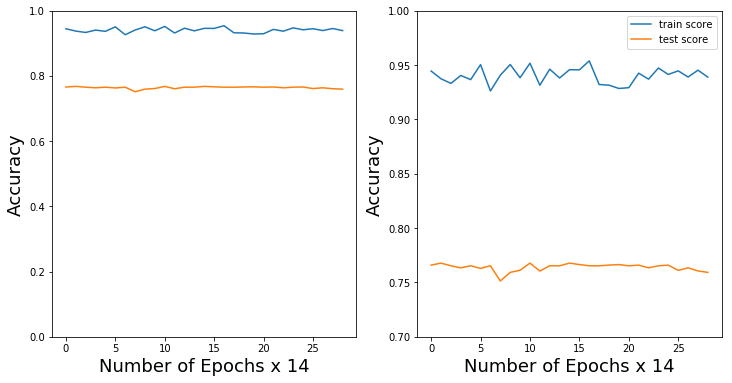

In [47]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=num_epochs, graph=True)



In [37]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dicat:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv.0.conv1.0.weight 	 torch.Size([32, 1, 3, 3])
conv.0.conv1.0.bias 	 torch.Size([32])
conv.0.conv1.1.weight 	 torch.Size([32])
conv.0.conv1.1.bias 	 torch.Size([32])
conv.0.conv1.1.running_mean 	 torch.Size([32])
conv.0.conv1.1.running_var 	 torch.Size([32])
conv.0.conv1.1.num_batches_tracked 	 torch.Size([])
conv.0.conv2.0.weight 	 torch.Size([32, 32, 3, 3])
conv.0.conv2.0.bias 	 torch.Size([32])
conv.0.conv2.1.weight 	 torch.Size([32])
conv.0.conv2.1.bias 	 torch.Size([32])
conv.0.conv2.1.running_mean 	 torch.Size([32])
conv.0.conv2.1.running_var 	 torch.Size([32])
conv.0.conv2.1.num_batches_tracked 	 torch.Size([])
conv.1.conv1.0.weight 	 torch.Size([64, 32, 3, 3])
conv.1.conv1.0.bias 	 torch.Size([64])
conv.1.conv1.1.weight 	 torch.Size([64])
conv.1.conv1.1.bias 	 torch.Size([64])
conv.1.conv1.1.running_mean 	 torch.Size([64])
conv.1.conv1.1.running_var 	 torch.Size([64])
conv.1.conv1.1.num_batches_tracked 	 torch.Size([])
conv.1.conv2.0.weight 	 torch.Size([

### STEP 8: SAVING THE MODEL

In [50]:
state = {
    'epoch': num_epochs,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(state, MODELPATH+'cnn_pretrained.model')

In [49]:
model

CNNModel(
  (conv): Sequential(
    (0): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, mom